In [116]:
import numpy as np
from scipy import sparse

## exact diagonalization

In [117]:
from quspin.basis import spin_basis_1d, spin_basis_general
from quspin.operators import hamiltonian,quantum_operator
from quspin.tools.lanczos import lanczos_full,lanczos_iter,FTLM_static_iteration,LTLM_static_iteration
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [133]:
Lx, Ly = 4, 4 # linear dimension of spin 1 2d lattice
N_2d = Lx*Ly # number of sites for spin 1
s = np.arange(N_2d) # sites [0,1,2,....]
x = s%Lx # x positions for sites
y = s//Lx # y positions for sites
T_x = (x+1)%Lx + Lx*y # translation along x-direction
T_y = x +Lx*((y+1)%Ly) # translation along y-direction
P_x = x + Lx*(Ly-y-1) # reflection about x-axis
P_y = (Lx-x-1) + Lx*y # reflection about y-axis
Z   = -(s+1) # spin inversion
# basis_2d = spin_basis_general(N_2d,pauli=False)
spin_basis_general(N_2d,kxblock=(T_x,0),kyblock=(T_y,0),pxblock=(P_x,0),pyblock=(P_y,0),zblock=(Z,0), pauli=True)

# set up coupling 
J1 = 0.5
J2 = 1
J_zz = [[J1,i,T_x[i]] for i in range(N_2d)]+[[J1,i,T_y[i]] for i in range(N_2d)] 
J_zz = J_zz + [[J2,0,5],[J2,2,7],[J2,8,13],[J2,10,15],[J2,1,14],[J2,3,12],[J2,6,9],[J2,4,11]]
J_xy = [[J1/2.0,i,T_x[i]] for i in range(N_2d)]+[[J1/2.0,i,T_y[i]] for i in range(N_2d)]
J_xy = J_xy + [[J2/2.0,0,5],[J2/2.0,2,7],[J2/2.0,8,13],[J2/2.0,10,15],[J2/2.0,1,14],[J2/2.0,3,12],[J2/2.0,6,9],[J2/2.0,4,11]]
ops_dict = dict(Jpm=[["+-",J_xy]],Jmp=[["-+",J_xy]],Jzz=[["zz",J_zz]])

/tmp/ipykernel_31221/714237641.py:12: GeneralBasisWarning: using non-commuting symmetries can lead to unwanted behaviour of general basis, make sure that quantum numbers are invariant under non-commuting symmetries!
  spin_basis_general(N_2d,kxblock=(T_x,0),kyblock=(T_y,0),pxblock=(P_x,0),pyblock=(P_y,0),zblock=(Z,0), pauli=True)


In [134]:
E = []
# for i in range(Lx*Ly+1):
basis_2d = spin_basis_general(N_2d ,pauli=False)
H = quantum_operator(ops_dict,basis=basis_2d,dtype=np.float64, check_symm=False)
[E0] = H.eigsh(k=1,which="SA",return_eigenvectors=False)
print(f"analitic = {-3/8 * N_2d * J2}, exact diagonalization = {E0}")

Hermiticity check passed!
analitic = -6.0, exact diagonalization = -5.999999999999992


In [127]:
import scipy 
A = H_.tocsc()
E = scipy.sparse.linalg.eigsh(A, k = 1, return_eigenvectors=False, which='SA')
print("ground energy = ", E[0])

ground energy =  -5.999999999999986


In [36]:
from __future__ import print_function, division
#
import sys,os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # uncomment this line if omp error occurs on OSX for python 3
os.environ['OMP_NUM_THREADS']='1' # set number of OpenMP threads to run in parallel
os.environ['MKL_NUM_THREADS']='1' # set number of MKL threads to run in parallel
#
quspin_path = os.path.join(os.getcwd(),"../../")
sys.path.insert(0,quspin_path)
#######################################################################
#                            example 21                               #    
# This example shows how to use the `Lanczos` submodule of the        #
# `tools` module to compute finite temperature expectation values     #
# using `FTLM_statc_iteration` and `LTLM_statiic_iteration`.          #
#######################################################################
from quspin.basis import spin_basis_1d
from quspin.operators import hamiltonian,quantum_operator
from quspin.tools.lanczos import lanczos_full,lanczos_iter,FTLM_static_iteration,LTLM_static_iteration
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [37]:
def bootstrap_mean(O_r,Id_r,n_bootstrap=100):
    """
    Uses boostraping to esimate the error due to sampling.

    O_r: numerator
    Id_r: denominator
    n_bootstrap: bootstrap sample size

    """
    O_r = np.asarray(O_r)
    Id_r = np.asarray(Id_r)
    #
    avg = np.nanmean(O_r,axis=0)/np.nanmean(Id_r,axis=0)
    n_Id = Id_r.shape[0]
    #n_N = O_r.shape[0]
    #
    i_iter = (np.random.randint(n_Id,size=n_Id) for i in range(n_bootstrap))
    #
    bootstrap_iter = (np.nanmean(O_r[i,...],axis=0)/np.nanmean(Id_r[i,...],axis=0) for i in i_iter)
    diff_iter = ((bootstrap-avg)**2 for bootstrap in bootstrap_iter)
    err = np.sqrt(sum(diff_iter)/n_bootstrap)
    #
    return avg,err
class lanczos_wrapper(object):
    """
    Class that contains minimum requirments to use Lanczos. 
    
    Using it is equired, since the dot and dtype methods of quantum_operator objects take more parameters 
    
    """
    #
    def __init__(self,A,**kwargs):
        """
        A: array-like object to assign/overwrite the dot and dtype objects of
        kwargs: any optional arguments used when overwriting the methods

        """
        self._A = A
        self._kwargs = kwargs
    #
    def dot(self,v,out=None):
        """
        Calls the `dot` method of quantum_operator with the parameters fixed to a given value.

        """
        return self._A.dot(v,out=out,pars=self._kwargs)
    #
    @property
    def dtype(self):
        """
        The dtype attribute is required to figure out result types in lanczos calculations.

        """
        return self._A.dtype

In [75]:
L = N_2d # system size
N_samples = 100 # of samples to approximate thermal expectation value with
m = 50 # dimensio of Krylov space
T = np.logspace(-1.6, 0.3, num=50) # temperature vector
beta = 1.0/(T+1e-15) # inverse temperature vector
H_wrapped = lanczos_wrapper(H_)
out = np.zeros((m,H_.Ns),dtype=np.float64)
[E0] = H_.eigsh(k=1,which="SA",return_eigenvectors=False)

In [88]:
np.load("SS_J_1_N_50x10.npy")

array([[ 3.01980663e-14,  6.31227054e-01,  1.36618171e+00,
         1.39106865e+00,  1.69550212e+00,  1.77182808e+00,
         2.00695334e+00,  2.21697515e+00,  2.49428910e+00,
         2.73588607e+00,  3.09433914e+00,  3.42404442e+00,
         3.78228314e+00,  4.16137111e+00,  4.54874301e+00,
         4.97410078e+00,  5.40337710e+00,  5.84209386e+00,
         6.30667042e+00,  6.76805887e+00,  7.24467071e+00,
         7.72226742e+00,  8.20963043e+00,  8.70430374e+00,
         9.19490088e+00,  9.68899413e+00,  1.01761003e+01,
         1.06788946e+01,  1.11509705e+01,  1.16359442e+01,
         1.21087390e+01,  1.25773918e+01,  1.30312356e+01,
         1.34769759e+01,  1.39080271e+01,  1.43107778e+01,
         1.47165110e+01,  1.50814566e+01,  1.54335268e+01,
         1.57714016e+01,  1.60386065e+01,  1.63224556e+01,
         1.66269613e+01,  1.67929353e+01,  1.69678605e+01,
         1.71177907e+01,  1.73433348e+01,  1.76242644e+01,
         1.82422984e+01,  1.96242644e+01],
       [-1.77

In [98]:
np.save("Hi", H_)

In [109]:
import pickle
with open('test.pickle', 'wb') as handle:
    pickle.dump(H_, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('test.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [95]:
M2_FT_list = []
M2_LT_list = []
Z_FT_list = []
Z_LT_list = []
Es = np.load("SS_E_J_1_N_50x50.npy")
Vs = np.load("SS_V_J_1_N_50x50.npy")
lvs = np.load("SS_lv_J_1_N_50x50.npy")

for i in range(len(lvs)):
    E,V,lv = Es[i], Vs[i], lvs[i]
    results_FT,Id_FT = FTLM_static_iteration({"E":H_},E,V,lv,beta=beta)
    results_LT,Id_LT = LTLM_static_iteration({"E":H_},E,V,lv,beta=beta)
    # save results to a list
    M2_FT_list.append(results_FT["E"])
    Z_FT_list.append(Id_FT)
    M2_LT_list.append(results_LT["E"])
    Z_LT_list.append(Id_LT)

In [96]:
# calculating error bars on the expectation values
m2_FT,dm2_FT = bootstrap_mean(M2_FT_list,Z_FT_list)
m2_LT,dm2_LT = bootstrap_mean(M2_LT_list,Z_LT_list)

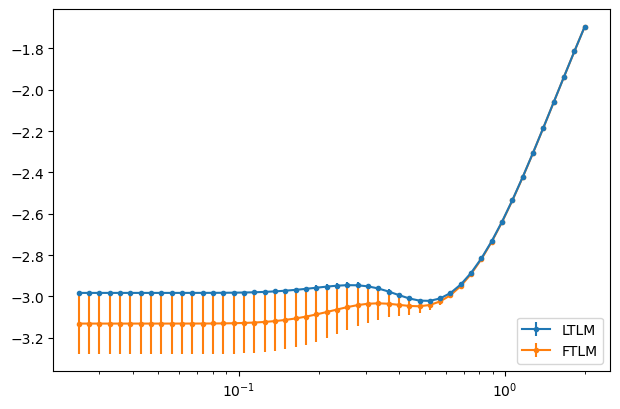

In [92]:
##### plot results #####
#
# setting up plot and inset
h=4.2 # figure aspect ratio parameter
f,ax = plt.subplots(figsize=(1.5*h,h))
# axinset = inset_axes(ax, width="45%", height="65%", loc="upper right")
# axs = [ax,axinset]
#
# plot results for FTLM and LTLM.
# for a in axs:
ax.errorbar(T,m2_LT,dm2_LT,marker=".",label="LTLM",zorder=-1)
ax.errorbar(T,m2_FT,dm2_FT,marker=".",label="FTLM",zorder=-2)
#
ax.set_xscale("log")
#
# adding space for inset by expanding x limits.
xmin,xmax = ax.get_xlim()
# ax.set_xlim((xmin,10*xmax))
ax.legend(loc="lower right")
# #
# # inset adjustment to zoom in low-temp limit.
# xmin,xmax = axinset.get_xlim()
# #
# a = -0.6
# m = np.logical_and(T>=xmin,T<=10**(a))
# axinset.set_xlim((xmin,10**(a+0.1)))
# ymin = min(m2_LT[m].min(),m2_FT[m].min())
# ymax = max(m2_LT[m].max(),m2_FT[m].max())
# ywin = ymax-ymin
# boundy = 0.1*ywin
# axinset.set_ylim((ymin-boundy,ymax+boundy))
#
# display plot
f.tight_layout()

## apply unitary transformation to Shastry-Sutherland

local state will be transformed from standard basis to singlet & triplet.

### original local hamiltonian

In [4]:
I = np.identity(2)
Sz = np.zeros([2,2])
Sz[0,0] = 1/2
Sz[1,1] = -1/2
Sx = np.zeros([2,2])
Sx[1,0] = 1/2
Sx[0,1] = 1/2
Sy = np.zeros([2,2], dtype=np.complex64)
Sy[1,0] = 1j/2
Sy[0,1] = -1j/2


Sz = sparse.csr_matrix(Sz)
Sx = sparse.csr_matrix(Sx)
Sy = sparse.csr_matrix(Sy)
I = sparse.csr_matrix(I)

h1 = -(sparse.kron(sparse.kron(I,Sz,format='csr'), sparse.kron(Sz,I,format='csr'),format='csr') 
       - sparse.kron(sparse.kron(I,Sx,format='csr'), sparse.kron(Sx,I,format='csr'),format='csr')
       - sparse.kron(sparse.kron(I,Sy,format='csr'), sparse.kron(Sy,I,format='csr'),format='csr') 
     ).real


h2 = -(sparse.kron(sparse.kron(Sz,I,format='csr'), sparse.kron(Sz,I,format='csr'),format='csr') 
       - sparse.kron(sparse.kron(Sx,I,format='csr'), sparse.kron(Sx,I,format='csr'),format='csr')
       - sparse.kron(sparse.kron(Sy,I,format='csr'), sparse.kron(Sy,I,format='csr'),format='csr') 
     ).real


h3 = -(sparse.kron(sparse.kron(Sz,Sz,format='csr'), sparse.kron(I,I,format='csr'),format='csr') 
       + sparse.kron(sparse.kron(Sx,Sx,format='csr'), sparse.kron(I,I,format='csr'),format='csr')
       + sparse.kron(sparse.kron(Sy,Sy,format='csr'), sparse.kron(I,I,format='csr'),format='csr') 
     ).real

h4 = -(sparse.kron(sparse.kron(I,I,format='csr'), sparse.kron(Sz,Sz,format='csr'),format='csr') 
       + sparse.kron(sparse.kron(I,I,format='csr'), sparse.kron(Sx,Sx,format='csr'),format='csr')
       + sparse.kron(sparse.kron(I,I,format='csr'), sparse.kron(Sy,Sy,format='csr'),format='csr') 
     ).real




h1_ = -(sparse.kron(sparse.kron(Sz,I,format='csr'), sparse.kron(I,Sz,format='csr'),format='csr') 
       - sparse.kron(sparse.kron(Sx,I,format='csr'), sparse.kron(I,Sx,format='csr'),format='csr')
       - sparse.kron(sparse.kron(Sy,I,format='csr'), sparse.kron(I,Sy,format='csr'),format='csr') 
     ).real

h2_ = -(sparse.kron(sparse.kron(I,Sz,format='csr'), sparse.kron(I,Sz,format='csr'),format='csr') 
       - sparse.kron(sparse.kron(I,Sx,format='csr'), sparse.kron(I,Sx,format='csr'),format='csr')
       - sparse.kron(sparse.kron(I,Sy,format='csr'), sparse.kron(I,Sy,format='csr'),format='csr') 
     ).real



h = h1 + h2
 
h_ = h1_ + h2_

on_site = h3/4 + h4/4


In [6]:
print(h1+h2)

  (0, 0)	-0.5
  (1, 1)	-0.5
  (2, 2)	0.5
  (2, 4)	0.5
  (2, 8)	0.5
  (3, 3)	0.5
  (3, 5)	0.5
  (3, 9)	0.5
  (4, 2)	0.5
  (5, 3)	0.5
  (6, 12)	0.5
  (7, 13)	0.5
  (8, 2)	0.5
  (9, 3)	0.5
  (10, 12)	0.5
  (11, 13)	0.5
  (12, 6)	0.5
  (12, 10)	0.5
  (12, 12)	0.5
  (13, 7)	0.5
  (13, 11)	0.5
  (13, 13)	0.5
  (14, 14)	-0.5
  (15, 15)	-0.5


### construct unitary transformation

In [7]:
u = np.array([
    [0,1,0,0],
    [1/np.sqrt(2), 0, 1/np.sqrt(2), 0],
    [-1/np.sqrt(2), 0, 1/np.sqrt(2), 0],
    [0,0,0,1]
])
u = sparse.csr_matrix(u)
U = sparse.kron(u, u,format='csr')

In [8]:
H = U.T @ h @ U
H2 = U.T @ h_ @ U
ON = U.T @ on_site @ U

In [9]:
print(H)

  (9, 4)	-0.4999999999999999
  (6, 4)	-0.4999999999999999
  (5, 5)	-0.5
  (9, 6)	0.4999999999999999
  (4, 6)	-0.4999999999999999
  (7, 7)	0.5
  (8, 7)	0.4999999999999999
  (10, 7)	0.4999999999999999
  (13, 8)	-0.4999999999999999
  (7, 8)	0.4999999999999999
  (4, 9)	-0.4999999999999999
  (6, 9)	0.4999999999999999
  (13, 10)	0.4999999999999999
  (7, 10)	0.4999999999999999
  (12, 11)	0.4999999999999999
  (14, 11)	0.4999999999999999
  (11, 12)	0.4999999999999999
  (14, 12)	0.4999999999999999
  (8, 13)	-0.4999999999999999
  (10, 13)	0.4999999999999999
  (13, 13)	0.5
  (11, 14)	0.4999999999999999
  (12, 14)	0.4999999999999999
  (15, 15)	-0.5


In [41]:
def num2state(s, L = 4):
    state = []
    for i in range(L):
        state.append(s%4)
        s >>= 2
    return state[::-1]

In [43]:
def state2num(state):
    s = 0
    for i in range(len(state)):
        s <<=2
        s += state[i]
    return s

In [21]:
np.load("array/SS_bond_test1.npy")[0,1]

0.0

In [19]:
ls

SS_hamiltonian.ipynb      check_conn_from_index.py  simple_4site_model.ipynb
Untitled1.ipynb           heisernberg.ipynb         test.py
array/                    make_SS_local.py          visualize.ipynb
check_conn.py             shastry_exact.py


In [ ]:
with open('readme.txt', 'w') as f:
    f.write('readme')

In [52]:
with open('readme.txt', 'w') as f:
    H_tmp = (H+ON).toarray()
    f.write("{:>6} ".format(""))
    for j in range(H_tmp.shape[1]):
        f.write("{:>6}  ".format(str(num2state(j, 2))))

    f.write("\n\n")
    for i in range(H_tmp.shape[0]):
    #     print("{:>6}".format(""), end="")
        f.write("{:>6}".format(str(num2state(i, 2))))
        for j in range(H_tmp.shape[1]):    
            f.write("{:>6.3f}, ".format(H_tmp[i,j]))
        f.write("\n")